In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
# Use for conda env:tfkGPU - otherwise comment out
import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

In [3]:
train_df = pd.read_csv('../data/cleaned_gc_data/gc_train.csv', index_col= 'Unnamed: 0')
test_df = pd.read_csv('../data/cleaned_gc_data/gc_test.csv', index_col= 'Unnamed: 0')

In [4]:
train_df.head()

,secs,power,hr,cad
0,0,0.0,74.0,0.0
1,1,1.0,75.0,22.0
2,2,11.0,76.0,22.0
3,3,53.0,77.0,48.0
4,4,102.0,78.0,49.0


In [5]:
test_df.head()

,secs,power,hr,cad
0,0,75,90.0,76.0
1,1,95,100.0,76.0
2,2,89,100.0,75.0
3,3,92,100.0,78.0
4,4,141,100.0,80.0


In [6]:
# Scaling the data
mm_scaler = MinMaxScaler()
train_data_scaled = mm_scaler.fit_transform(train_df)
test_data_scaled = mm_scaler.fit_transform(test_df)

In [7]:
pd.DataFrame(train_data_scaled)

,0,1,2,3
0,0.000000,0.000000,0.418079,0.000000
1,0.000161,0.001222,0.423729,0.130952
2,0.000322,0.013447,0.429379,0.130952
3,0.000483,0.064792,0.435028,0.285714
4,0.000644,0.124694,0.440678,0.291667
...,...,...,...,...
110028,0.560026,0.000000,0.514124,0.000000
110029,0.560187,0.000000,0.514124,0.000000
110030,0.560348,0.000000,0.514124,0.000000
110031,0.560509,0.000000,0.514124,0.000000


In [8]:
# Train/Test Split
X_train = train_data_scaled
X_test = test_data_scaled
y_train = train_data_scaled[:,2] # column 2 is the target column: heart rate
y_test = test_data_scaled[:,2]

In [9]:
X_train.shape

(110033, 4)

In [10]:
X_test.shape

(20459, 4)

In [11]:
y_train.shape

(110033,)

In [12]:
y_test.shape

(20459,)

In [13]:
win_length = 70
batch_size= 32
num_features = X_train.shape[1]

# Create training sequences
train_generator = TimeseriesGenerator(X_train, y_train, length= win_length, sampling_rate= 1, batch_size= batch_size )

# Create test sequences
test_generator = TimeseriesGenerator(X_test, y_test, length= win_length, sampling_rate= 1, batch_size= batch_size )

In [14]:
train_generator[0][0].shape

(32, 70, 4)

In [15]:
# LSTM Model 2
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences= False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 70, 128)           68096     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 70, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 128)           131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 70, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 70, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [17]:
# Compile and fit the model
model.compile(loss= tf.losses.MeanSquaredError(),
              optimizer= tf.optimizers.Adam()
             )

history = model.fit(train_generator, epochs= 50,
                              validation_data= test_generator,
                              shuffle= False
                             )

Epoch 1/50
3437/3437 [==============================] - 69s 20ms/step - loss: 0.0076 - val_loss: 0.0121
Epoch 2/50
3437/3437 [==============================] - 58s 17ms/step - loss: 0.0035 - val_loss: 0.0057
Epoch 3/50
3437/3437 [==============================] - 58s 17ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 4/50
3437/3437 [==============================] - 58s 17ms/step - loss: 5.8566e-04 - val_loss: 0.0020
Epoch 5/50
3437/3437 [==============================] - 58s 17ms/step - loss: 4.7836e-04 - val_loss: 0.0013
Epoch 6/50
3437/3437 [==============================] - 59s 17ms/step - loss: 3.8190e-04 - val_loss: 0.0013
Epoch 7/50
3437/3437 [==============================] - 58s 17ms/step - loss: 3.2916e-04 - val_loss: 0.0015
Epoch 8/50
3437/3437 [==============================] - 58s 17ms/step - loss: 3.1534e-04 - val_loss: 0.0013
Epoch 9/50
3437/3437 [==============================] - 58s 17ms/step - loss: 2.9778e-04 - val_loss: 0.0014
Epoch 10/50
3437/3437 [=================

In [18]:
train_preds = model.predict(train_generator)
test_preds = model.predict(test_generator)

In [19]:
r2_score(y_train[win_length:], train_preds), r2_score(y_test[win_length:], test_preds)

(0.9937482457590523, 0.993333715663646)

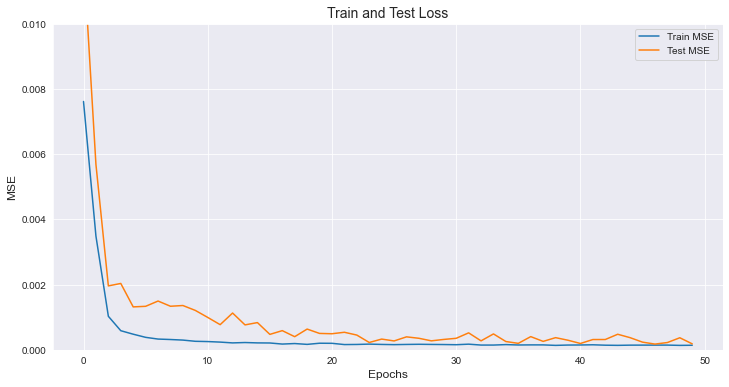

In [24]:
# Plot train and test loss (Mean Squared Error)
sns.set_style('darkgrid')
plt.figure(figsize= (12, 6))
plt.title('Train and Test Loss', fontsize= 14)
plt.plot(history.history['loss'], label= 'Train MSE')
plt.plot(history.history['val_loss'], label= 'Test MSE')
plt.ylabel('MSE', fontsize= 12)
plt.xlabel('Epochs', fontsize= 12)
plt.legend()
plt.ylim(0, .01)
plt.savefig('../visualizations/gc_model_loss.jpg', bbox_inches='tight');

In [25]:
# Create a dataframe that will hold the predictions for y as well as the original values for X
hr_test_results_sc = pd.DataFrame(X_test[win_length:])
hr_test_results_sc[2] = test_preds

In [26]:
hr_test_results_sc.head()

,0,1,2,3
0,0.012861,0.223638,0.701811,0.616883
1,0.013044,0.310545,0.702078,0.642857
2,0.013228,0.323291,0.711329,0.610390
3,0.013412,0.294322,0.712460,0.610390
4,0.013595,0.225956,0.720719,0.597403


In [27]:
# Now we need to de-scale the data for interpretability
# Column '2' is y_test predictions, de-scaled
hr_test_results = pd.DataFrame(mm_scaler.inverse_transform(hr_test_results_sc))
hr_test_results.head()

,0,1,2,3
0,70.0,193.0,143.584736,95.0
1,71.0,268.0,143.611906,99.0
2,72.0,279.0,144.555520,94.0
3,73.0,254.0,144.670961,94.0
4,74.0,195.0,145.513342,92.0


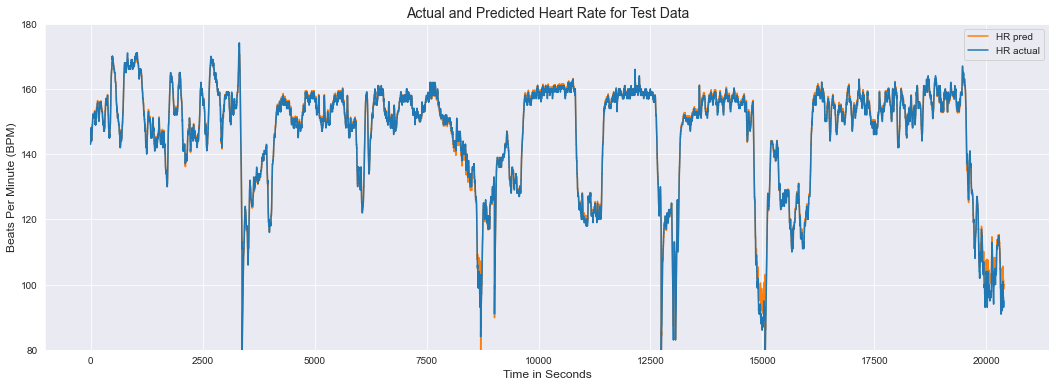

In [59]:
# Visualize the actual and predicted heart rate for the full test dataset
sns.set_style('darkgrid')
plt.figure(figsize= (18, 6))
plt.title('Actual and Predicted Heart Rate for Test Data', fontsize= 14)
plt.plot(hr_test_results[2], color = 'tab:orange', label= 'HR pred')
plt.plot(pd.DataFrame(test_df['hr'][win_length:]).reset_index().drop('index', axis= 1), color= 'tab:blue', label= 'HR actual')
plt.ylim(80, 180)
plt.xlabel('Time in Seconds', fontsize= 12)
plt.ylabel('Beats Per Minute (BPM)', fontsize= 12)
plt.legend()
plt.savefig(f'../visualizations/full_test.jpg', bbox_inches='tight');

In [29]:
# Save the model
model.save('../models/gc_rnn_model/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/gc_rnn_model/assets


In [30]:
# Reload model to test and verify that it was saved properly
reconstructed_model = keras.models.load_model('../models/gc_rnn_model/')

In [31]:
# Generate predictions
recon_train_preds = reconstructed_model.predict(train_generator)
recon_test_preds = reconstructed_model.predict(test_generator)

In [32]:
# Train and test r2 scores
r2_score(y_train[win_length:], recon_train_preds), r2_score(y_test[win_length:], recon_test_preds)

(0.9937482457590523, 0.993333715663646)

## Test the model with individual workouts

In [33]:
# Read in the workout to a dataframe
test_1_df = pd.read_csv('../data/cleaned_gc_data/gc_test_1.csv', index_col= 'Unnamed: 0')
test_2_df = pd.read_csv('../data/cleaned_gc_data/gc_test_2.csv', index_col= 'Unnamed: 0')
test_3_df = pd.read_csv('../data/cleaned_gc_data/gc_test_3.csv', index_col= 'Unnamed: 0')
test_4_df = pd.read_csv('../data/cleaned_gc_data/gc_test_4.csv', index_col= 'Unnamed: 0')
test_5_df = pd.read_csv('../data/cleaned_gc_data/gc_test_5.csv', index_col= 'Unnamed: 0')

In [34]:
# Takes an individual workout dataframe as input and returns an identical dataframe, but 
# with model predictions in the target column of the dataframe. The function also prints the r2 score

def score_get_predictions(cur_test_df):

    # Scale the data down
    cur_test_data_sc = mm_scaler.fit_transform(cur_test_df)

    # Define X and y test for the workout
    cur_X_test_sc = cur_test_data_sc
    cur_y_test_sc = cur_test_data_sc[:,2]
    
    # Create test sequences
    cur_test_generator = TimeseriesGenerator(cur_X_test_sc, cur_y_test_sc, length= win_length, 
                                           sampling_rate= 1, batch_size= batch_size)
    
    # Generate predictions
    cur_test_preds_sc = reconstructed_model.predict(cur_test_generator)
    
    # print the r2 score
    print(f'Workout r2 score: {r2_score(cur_y_test_sc[win_length:], cur_test_preds_sc)}')
    
    # Create a dataframe that corresponds to the X testing data that the model used
    hr_test_results_sc = pd.DataFrame(cur_X_test_sc[win_length:])
    
    # Replace the original y column with predictions for y
    hr_test_results_sc[2] = cur_test_preds_sc
    
    # Restore all of the data to its original scale for interpretability
    # Column '2' is y_test predictions, de-scaled
    hr_test_results = pd.DataFrame(mm_scaler.inverse_transform(hr_test_results_sc))
    
    return hr_test_results

In [46]:
# Takes an original workout dataframe and one with target predictions as input, as well as the workout number,
# and displays a line plot of the actual and predicted heart rate

def visualize_workout(orig_df, preds_df, w_num):
    sns.set_style('darkgrid')
    plt.figure(figsize= (16, 6))
    plt.title(f'GC Workout {w_num} RNN Results', fontsize= 14)
    plt.plot(preds_df[2], color = 'tab:orange', label= 'HR pred')
    plt.plot(pd.DataFrame(orig_df['hr'][win_length:]).reset_index().drop('index', axis= 1), color= 'tab:blue', label= 'HR actual')
    plt.xlabel('Time in Seconds', fontsize= 12)
    plt.ylabel('Beats Per Minute (BPM)', fontsize= 12)
    plt.legend()
    plt.savefig(f'../visualizations/workout_{w_num}.jpg', bbox_inches='tight');
    return None

In [47]:
test_1_preds_df = score_get_predictions(test_1_df)

Workout r2 score: 0.9898315413373773


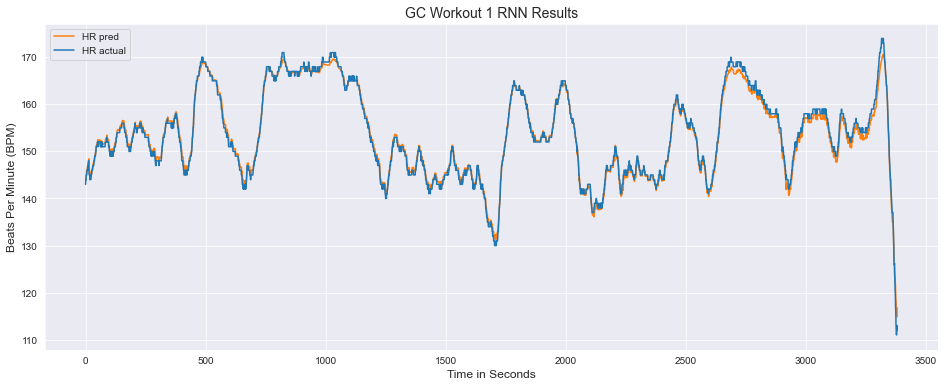

In [48]:
visualize_workout(test_1_df, test_1_preds_df, 1)

In [49]:
test_2_preds_df = score_get_predictions(test_2_df)

Workout r2 score: 0.967462064602365


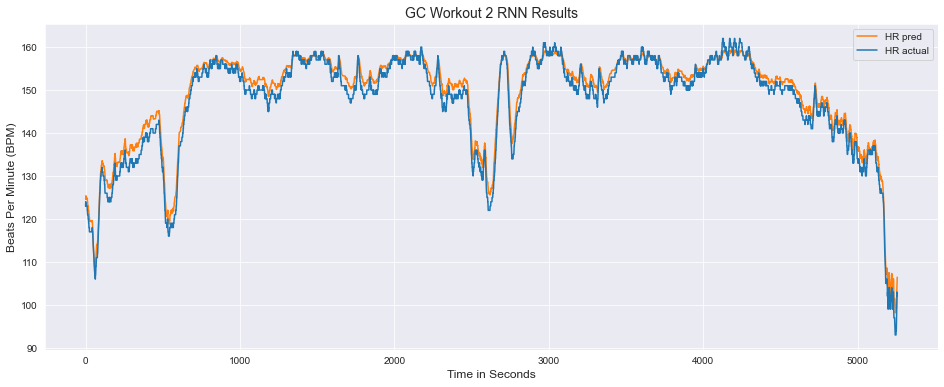

In [50]:
visualize_workout(test_2_df, test_2_preds_df, 2)

In [51]:
test_3_preds_df = score_get_predictions(test_3_df)

Workout r2 score: 0.9593331929863137


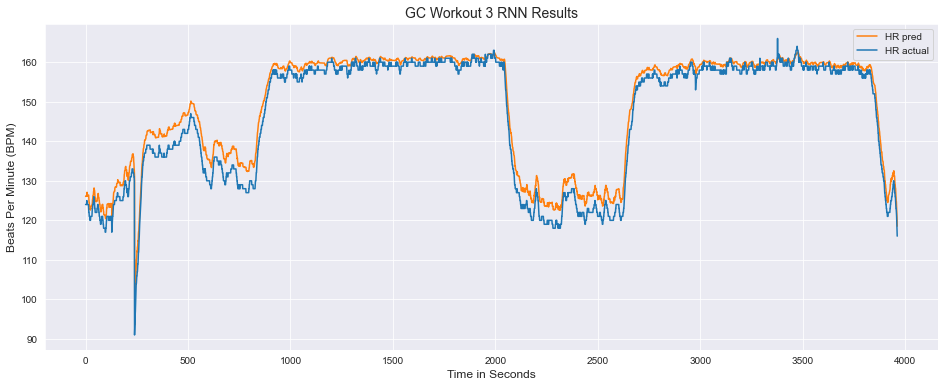

In [52]:
visualize_workout(test_3_df, test_3_preds_df, 3)

In [53]:
test_4_preds_df = score_get_predictions(test_4_df)

Workout r2 score: 0.9861088433176007


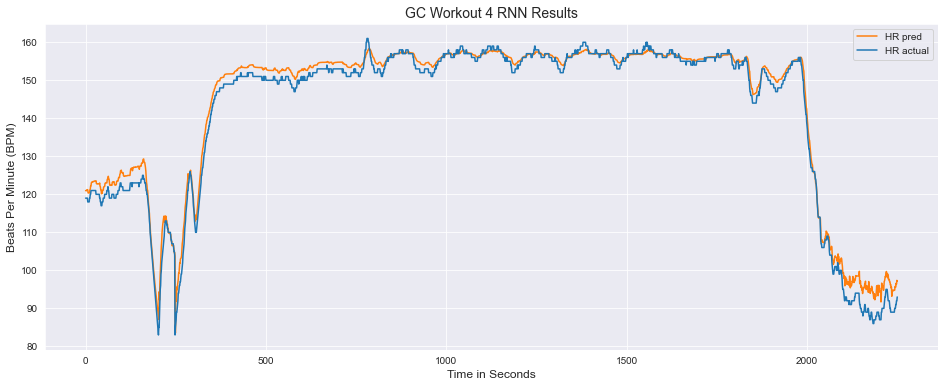

In [54]:
visualize_workout(test_4_df, test_4_preds_df, 4)

In [55]:
test_5_preds_df = score_get_predictions(test_5_df)

Workout r2 score: 0.9784573037189986


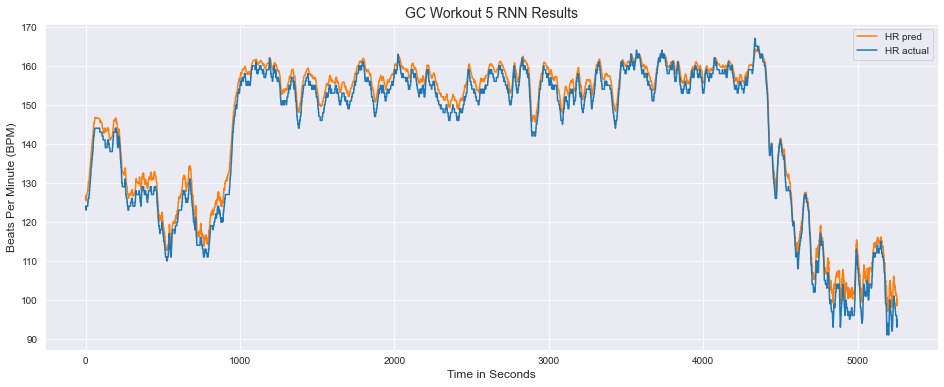

In [56]:
visualize_workout(test_5_df, test_5_preds_df, 5)